In [1]:
library(ggplot2)
library(ggpubr) #arrange multiple ggplot
library(readxl)
library(dplyr)
library(RColorBrewer)
library(reshape2) #now a bit outdated, but how I learned to reshape data
library(phyloseq)
library(caret)
library("vsn")
library(vegan)
library(stringr)
library(UpSetR)
library(MicrobiomeStat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to B

# Read phyloseq object

In [2]:
ps <- readRDS(file="/home/zeyang.shen/lab_data/personal/Zeyang/Vitality/RDS/bracken_results_ns38-46+56-57+62+66+94+96_Species_BasedOn_20220511_standard+SMGC+ELSGv2+ns66+T2T.Aug2025.t10.ps.rds")
ps <- subset_taxa(ps, Genus!="Homo")
sample_data.df <- sample_data(ps)
sample_data.df$total_abundance <- rowSums(otu_table(ps))
sample_data(ps) <- sample_data.df
ps <- subset_samples(ps, location!="novaseq6000")
ps <- subset_samples(ps, group!=".")
ps <- subset_samples(ps, !(site_specific %in% c("Ctrl", "PrepCtrl", "(empty)", "N", "ZymoD6306")))
ps <- tax_glom(ps, taxrank="Species", NArm=FALSE)
table(sample_data(ps)$babymom_site_visit, sample_data(ps)$group2)

         
          1_no 1_yes 2_no 2_yes 3_yes 4_no
  B:Ac:T1    5    11    2     5    29   28
  B:Ac:T3   22    71   24    30   169  108
  B:Ch:T1    5    11    2     5    28   28
  B:Ch:T3   22    72   24    30   169  108
  F:Ac:T3    0     0    0     0     2    1
  M:Ac:T3    0    10    1     0    30   26

[1] "Total samples: 1078"
[1] "Samples selected: 1072"
[1] "After filter on reads: 1068"
[1] "Subsampling to reads: 119027"


`set.seed(10)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(10); .Random.seed` for the full vector

...

1246OTUs were removed because they are no longer 
present in any sample after random subsampling


...



         
          1_no 1_yes 2_no 2_yes 3_yes 4_no
  B:Ac:T1    5    10    2     5    29   28
  B:Ac:T3   21    71   24    30   168  106
  B:Ch:T1    5    11    2     5    28   28
  B:Ch:T3   22    71   24    30   168  105
  F:Ac:T3    0     0    0     0     2    1
  M:Ac:T3    0    10    1     0    30   26

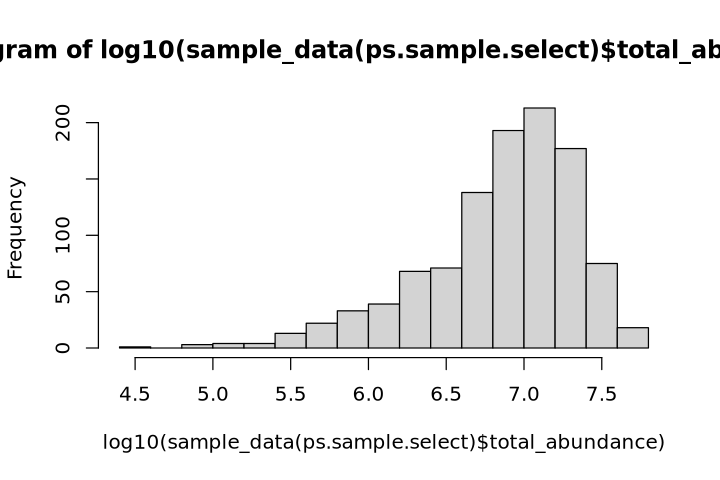

In [3]:
exclude_samples <- c("Met4959", "Met4960", #air control and Ac:T3 likely swapped
                     "Met5191", "Met5192", #control has more reads than samples
                     "Met4929", #similar number of reads as air control
                     "Met5528" #only 8700 total reads
                    )

#1.Select samples
print(paste("Total samples:", nsamples(ps)))
ps.sample.select <- subset_samples(ps, !(Sample %in% exclude_samples))
print(paste("Samples selected:", nsamples(ps.sample.select)))
options(repr.plot.width = 6, repr.plot.height = 4)
hist(log10(sample_data(ps.sample.select)$total_abundance))

##filter sample by total reads
ps.sample.select2 <- subset_samples(ps.sample.select, total_abundance > 100000)
print(paste("After filter on reads:", nsamples(ps.sample.select2)))

##rarefication
print(paste("Subsampling to reads:", min(rowSums(otu_table(ps.sample.select2)))))
ps.rarefy <- rarefy_even_depth(ps.sample.select2, rngseed=10)

table(sample_data(ps.sample.select2)$babymom_site_visit, sample_data(ps.sample.select2)$group2)

# Fig 2a

In [4]:
tax.tb <- as.data.frame(tax_table(ps.sample.select2))
cov.file <- "/home/zeyang.shen/lab_data/personal/Zeyang/Vitality/RefSeq+ELSG+SMGC.default.coverm.tsv"
cov.df <- read.csv(cov.file, sep="\t")
cov.df$Species <- unlist(lapply(cov.df[,1], function(x) {paste(unlist(str_split(x, " "))[1:2], collapse=" ")}))
cov.lst <- c()
for (s in tax.tb$Species){
    if (s %in% cov.df$Species){
        cov.lst <- c(cov.lst, max(cov.df[cov.df$Species==s,"X0.99"]))
    } else {
        cov.lst <- c(cov.lst, NaN)
    }
}
tax.tb$Coverage <- cov.lst

In [5]:
run_linda_on_phyloseq <- function(ps.deseq, 
                                  comparison_label = NULL, 
                                  n.cores = 16) {
  # Build feature table (relative abundance)
  feature.table <- data.frame(t(otu_table(ps.deseq)))
  rel_abund <- sweep(feature.table, 2, colSums(feature.table), FUN = "/")
  
  # Metadata
  meta.table <- data.frame(sample_data(ps.deseq))
  
  # Try LinDA
  tryCatch({
    linda.obj <- linda(
      rel_abund,
      meta.table,
      formula = "~group",
      feature.dat.type = "proportion",
      is.winsor = TRUE,
      prev.filter = 0.3,
      mean.abund.filter = 5e-5,
      p.adj.method = "BH",
      n.cores = n.cores
    )
    
    linda_output <- linda.obj$output[[1]]
    linda.res <- linda_output[, c("log2FoldChange", "padj")]
    colnames(linda.res) <- c("log2FC", "qval")
    linda.res$taxID <- rownames(linda.res)
    linda.res$method <- "LinDA"
    
    # Add taxonomic annotations if available
    display.df <- data.frame(linda.res, tax_table(ps.deseq)[linda.res$taxID,])
    if (!is.null(comparison_label)) {
      display.df$comparison <- comparison_label
    }
    
    # Add abundance and prevalence metrics
    display.df$abundance.median <- apply(otu_table(ps.deseq) / rowSums(otu_table(ps.deseq)), 2, median)[display.df$taxID]
    display.df$abundance.max <- apply(otu_table(ps.deseq) / rowSums(otu_table(ps.deseq)), 2, max)[display.df$taxID]
    display.df$prevalence <- apply(otu_table(ps.deseq), 2, function(x) sum(x > 0) / length(x))[display.df$taxID]
    display.df$coverage <- tax.tb[display.df$taxID, "Coverage"]    
    return(display.df)
    
  }, error = function(e) {
    message("LinDA failed: ", e$message)
    return(NULL)
  })
}

In [6]:
# Disease vs HC
comp1 <- c("1", "2", "3")
comp2 <- c("4", "4", "4")
DA.res <- c()

ps.subset <- subset_samples(ps.sample.select2, babymom_site_visit=="B:Ac:T3")
for (g in seq_len(length(comp1))){
    # AD, AD+FA, AD+FS
    for (affect in c("yes","no")){
        ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="yes"&skin_swab_taken_at_eczema_T3==affect)|(group==comp2[g]))
        print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$any_eczema_ever_d))
        cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"_Ac",affect,"vsGroup",comp2[g]))
        DA.res <- rbind(DA.res, cur.res)
        flush.console()
    }

    # FA or FS only
    ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="no")|(group==comp2[g]))
    print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$any_eczema_ever_d))
    cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"only_AcvsGroup",comp2[g]))
    DA.res <- rbind(DA.res, cur.res)
    flush.console()
}

ps.subset <- subset_samples(ps.sample.select2, babymom_site_visit=="B:Ch:T3")
for (g in seq_len(length(comp1))){
    # AD, AD+FA, AD+FS
    ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="yes")|(group==comp2[g]))
    print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$any_eczema_ever_d))
    cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"_ChvsGroup",comp2[g]))
    DA.res <- rbind(DA.res, cur.res)
    flush.console()

    # FA or FS only
    ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="no")|(group==comp2[g]))
    print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$any_eczema_ever_d))
    cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"only_ChvsGroup",comp2[g]))
    DA.res <- rbind(DA.res, cur.res)
    flush.console()
}

           
             no yes
  1_yes_yes   0  18
  4_no_no   106   0
8498  features are filtered!
The filtered data has  124  samples and  1014  features will be tested!
Fit linear models ...
Completed.
          
            no yes
  1_yes_no   0  52
  4_no_no  106   0
8509  features are filtered!
The filtered data has  158  samples and  1003  features will be tested!
Fit linear models ...
Completed.
         
           no
  1_no_no  21
  4_no_no 106
8498  features are filtered!
The filtered data has  127  samples and  1014  features will be tested!
Fit linear models ...
Completed.
           
             no yes
  2_yes_yes   0   8
  4_no_no   106   0
8499  features are filtered!
The filtered data has  114  samples and  1013  features will be tested!
Fit linear models ...
Completed.
          
            no yes
  2_yes_no   0  21
  4_no_no  106   0
8495  features are filtered!
The filtered data has  127  samples and  1017  features will be tested!
Fit linear models ...
Completed

LinDA failed: contrasts can be applied only to factors with 2 or more levels



           
             no yes
  1_yes_.     0   1
  1_yes_no    0  51
  1_yes_yes   0  19
  4_no_no   105   0
8838  features are filtered!
The filtered data has  176  samples and  674  features will be tested!
Fit linear models ...
Completed.
         
           no
  1_no_no  22
  4_no_no 105
8842  features are filtered!
The filtered data has  127  samples and  670  features will be tested!
Fit linear models ...
Completed.
           
             no yes
  2_yes_.     0   1
  2_yes_no    0  21
  2_yes_yes   0   8
  4_no_no   105   0
8829  features are filtered!
The filtered data has  135  samples and  683  features will be tested!
Fit linear models ...
Completed.
         
           no
  2_no_.    2
  2_no_no  22
  4_no_no 105
8840  features are filtered!
The filtered data has  129  samples and  672  features will be tested!
Fit linear models ...
Completed.
           
             no yes
  3_yes_no    0 125
  3_yes_yes   0  43
  4_no_no   105   0
8802  features are filtered!
The f

LinDA failed: contrasts can be applied only to factors with 2 or more levels



In [7]:
abund.cutoff <- 0
fc.cutoff <- 0
q.cutoff <- 0.1
cov.cutoff <- 0.6
# DA.res$qval <- p.adjust(DA.res$pval, method = "BH")
DA.res$log10q <- -log10(DA.res$qval)
DA.res$method_comparison <- paste0(DA.res$comparison, "_", DA.res$method)
DA.res <- DA.res[order(DA.res$qval),]

all.sig.taxa <- c()
for (comp in unique(DA.res$comparison)){
    print(comp)
    pos.sig.taxa1 <- subset(DA.res, comparison==comp & log2FC > fc.cutoff & abundance.median > abund.cutoff & (coverage > cov.cutoff | Genus=='Malassezia'))$taxID
    if (length(pos.sig.taxa1)>0){
        pos.mtx <- dcast(subset(DA.res, comparison==comp & taxID %in% pos.sig.taxa1), taxID+comparison~method, value.var = "qval", fill = 1)
        pos.sig.taxa2 <- subset(pos.mtx, (LinDA < q.cutoff))$taxID
        print(paste("Increased:", length(pos.sig.taxa2)))
        if (length(pos.sig.taxa2) > 0){print(tax.tb[pos.sig.taxa2,c("Species", "Coverage")])}
        all.sig.taxa <- c(all.sig.taxa, pos.sig.taxa2)
    }
    
    neg.sig.taxa1 <- subset(DA.res, comparison==comp & log2FC < -fc.cutoff & abundance.median > abund.cutoff & (coverage > cov.cutoff | Genus=='Malassezia'))$taxID
    if (length(neg.sig.taxa1)>0){
        neg.mtx <- dcast(subset(DA.res, comparison==comp & taxID %in% neg.sig.taxa1), taxID+comparison~method, value.var = "qval", fill = 1)
        neg.sig.taxa2 <- subset(neg.mtx, (LinDA < q.cutoff))$taxID
        print(paste("Decreased:", length(neg.sig.taxa2)))
        if (length(neg.sig.taxa2) > 0){print(tax.tb[neg.sig.taxa2,c("Species", "Coverage")])}
        all.sig.taxa <- c(all.sig.taxa, neg.sig.taxa2)
    }
}
DA.sig.res <- subset(DA.res, taxID %in% all.sig.taxa)
length(all.sig.taxa)

[1] "Group1_ChvsGroup4"
[1] "Increased: 3"
                  Species  Coverage
1358   Lactococcus lactis 0.7948115
1359 Lactococcus cremoris 0.8519898
1377  Aerococcus viridans 0.8871834
[1] "Decreased: 1"
                   Species Coverage
76776 Malassezia slooffiae      NaN
[1] "Group2_AcyesvsGroup4"
[1] "Increased: 4"
                          Species  Coverage
2682456     Veillonella nakazawae 0.8369411
28132   Prevotella melaninogenica 0.8940750
5000085   Veillonella sp018367495 0.7648865
5000108     Bulleidia sp015256455 0.9824055
[1] "Decreased: 0"
[1] "Group3_ChvsGroup4"
[1] "Increased: 0"
[1] "Decreased: 0"
[1] "Group1_AcnovsGroup4"
[1] "Increased: 0"
[1] "Decreased: 1"
                   Species Coverage
76776 Malassezia slooffiae      NaN
[1] "Group1_AcyesvsGroup4"
[1] "Increased: 4"
                       Species  Coverage
1290    Staphylococcus hominis 0.9092269
1358        Lactococcus lactis 0.7948115
1359      Lactococcus cremoris 0.8519898
5000159 Prevotella sp01507478

[1] 17

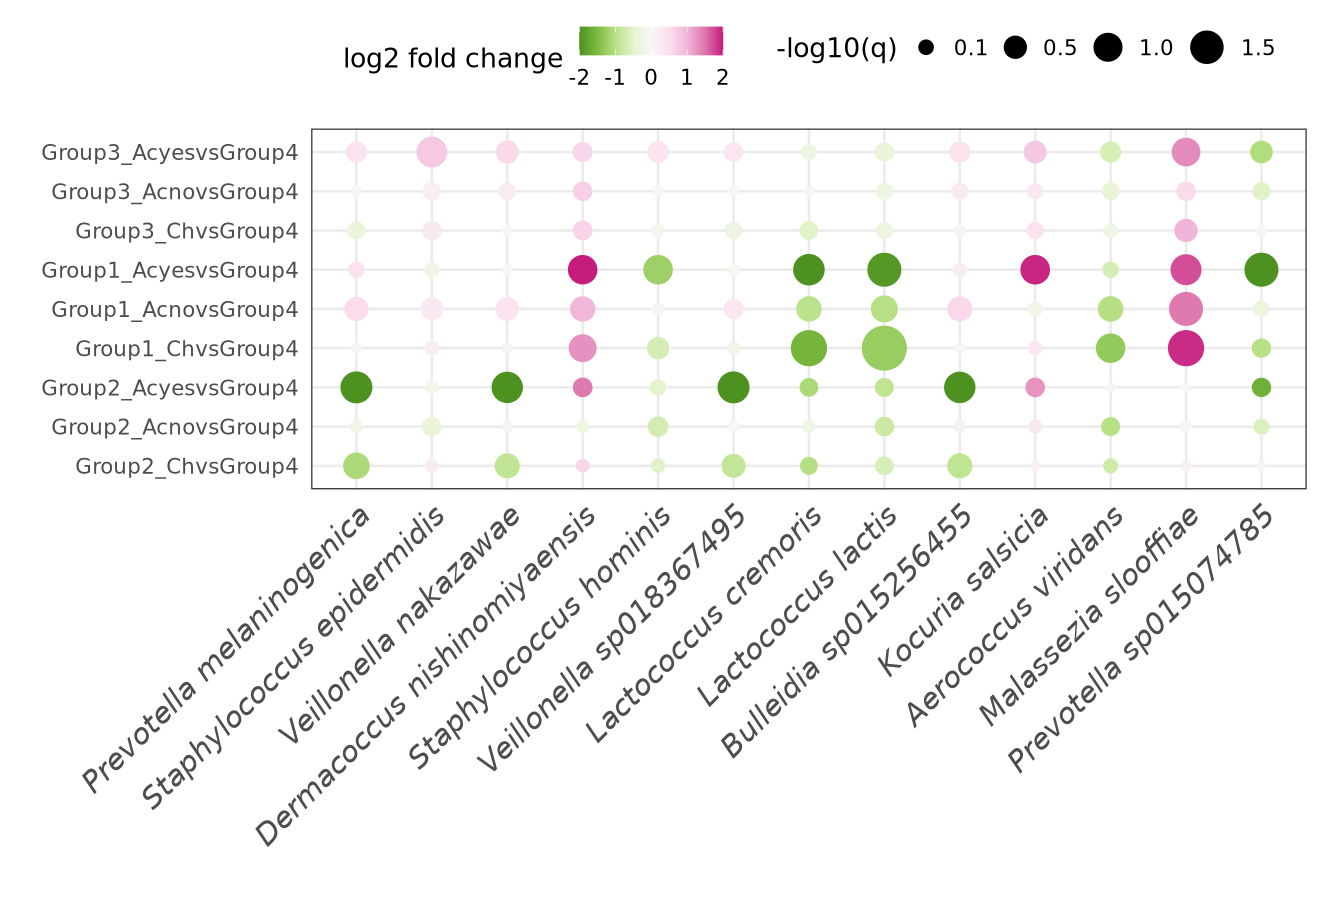

In [12]:
select.groups <- c("Group2_ChvsGroup4","Group2_AcnovsGroup4","Group2_AcyesvsGroup4",
                   "Group1_ChvsGroup4","Group1_AcnovsGroup4","Group1_AcyesvsGroup4",
                   "Group3_ChvsGroup4","Group3_AcnovsGroup4","Group3_AcyesvsGroup4")
DA.sig.res <- subset(DA.sig.res, comparison %in% select.groups)
DA.sig.res$comparison <- factor(DA.sig.res$comparison, level=select.groups)
colors <- colorRampPalette(rev(brewer.pal(9, "PiYG")))(255)
options(repr.plot.width = 11, repr.plot.height = 7.5)
dp1 <- ggplot(DA.sig.res, aes(x=reorder(Species, -abundance.median), y=comparison, color = -log2FC, size = log10q)) + 
    geom_point()+
    scale_color_gradientn(colours = colors, limits = c(-2,2), oob = scales::squish, name = 'log2 fold change')+
    scale_size_continuous(range=c(2,12), breaks=c(0.1,0.5,1,1.5), name='-log10(q)')+
    labs(x="", y="")+
    theme_bw(base_size=16)+
    theme(axis.text.x = element_text(size=18, angle = 45, vjust = 1, hjust=1, face="italic", family="Helvetica"), 
          legend.position='top')+
    theme(axis.ticks = element_blank())
dp1
ggsave(dp1, width=11, height=7.5, file="../figs/AD_DA_T3.eps", device="eps")

# Fig 2b

In [9]:
ps.subset2 <- subset_samples(ps.sample.select2, visit=="T3" & babymom=="B")
select_melt <- psmelt(ps.subset2)
select_melt$babymom_site_visit[select_melt$babymom_site_visit=='F:Ac:T3'] <- 'M:Ac:T3'

Warning message in psmelt(ps.subset2):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


In [10]:
substr <- "Prevotella melaninogenica" #Lactococcus cremoris, Staphylococcus epidermidis, Dermacoccus nishinomiyaensis, Malassezia slooffiae, Prevotella melaninogenica
display_set <- subset(select_melt, grepl(substr, Species))
unique(display_set$OTU)
select.group3 <- c("3_yes_yes", "3_yes_no", "1_yes_yes", "1_yes_no", "2_yes_yes", "2_yes_no", "1_no_no", "2_no_no","4_no_no")
select.group2 <- c("3_yes", "1_yes", "2_yes", "1_no", "2_no", "4_no")
display_set$new.group <- NA
display_set$new.group[display_set$babymom_site_visit == "B:Ac:T3"] <- display_set$group3[display_set$babymom_site_visit == "B:Ac:T3"]
display_set$new.group[display_set$babymom_site_visit == "B:Ch:T3"] <- display_set$group2[display_set$babymom_site_visit == "B:Ch:T3"]
display_set <- subset(display_set, new.group %in% c(select.group3, select.group2))
display_set$new.group <- factor(display_set$new.group, level=c(select.group3, select.group2))

[1] "28132"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


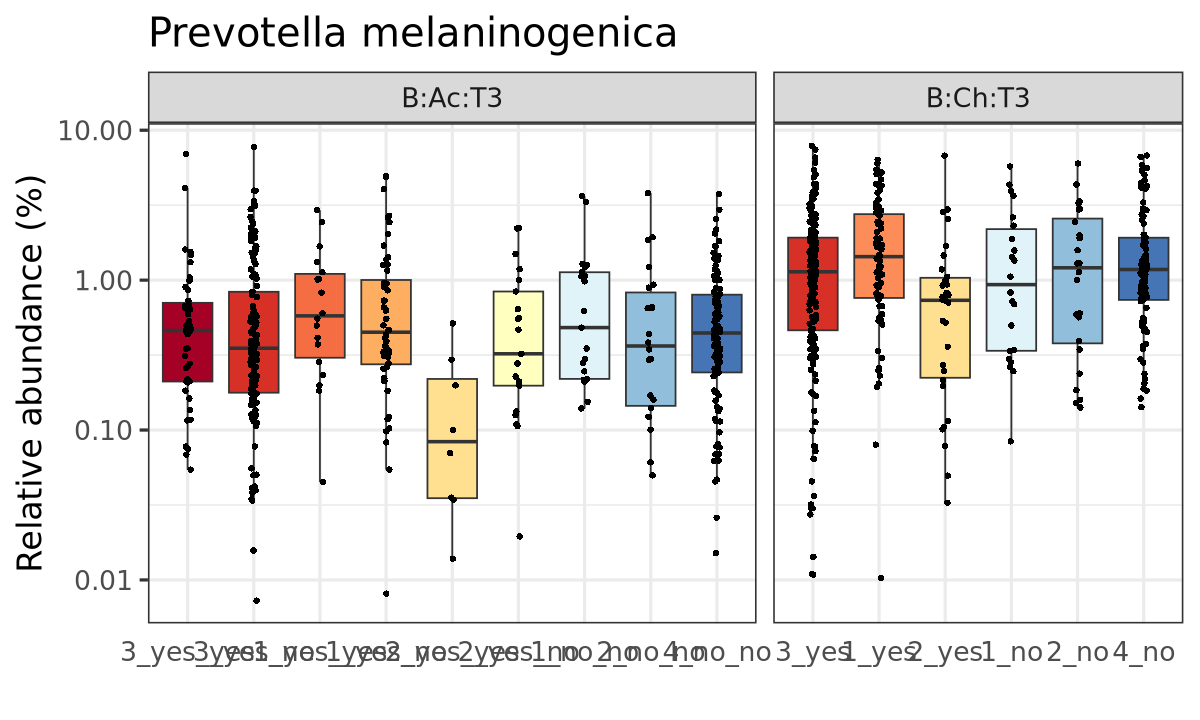

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


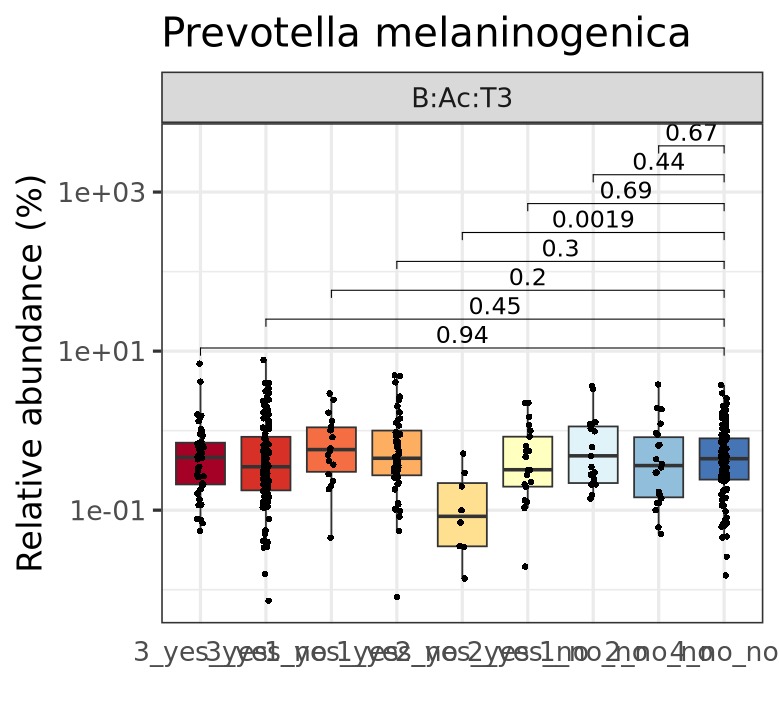

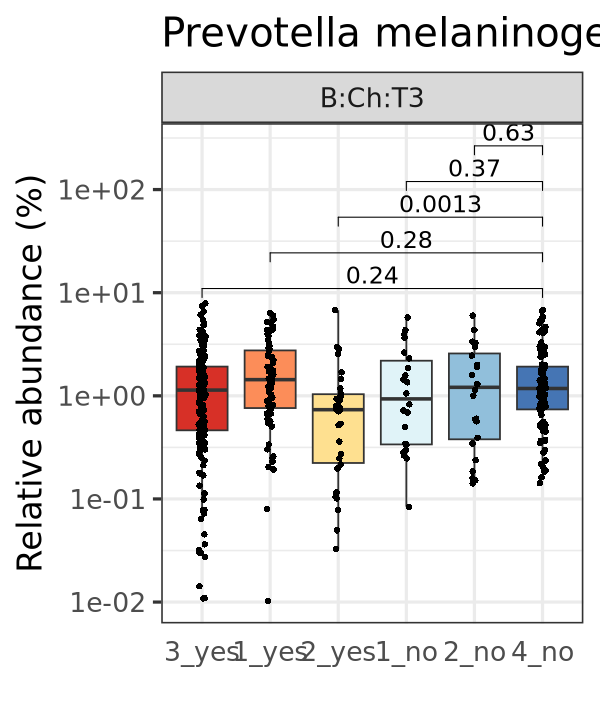

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)
my_cols <- c(brewer.pal(11, "RdYlBu")[1:6], brewer.pal(6, "RdYlBu")[4:6], brewer.pal(6, "RdYlBu")[1:6])
p.all <- ggplot(display_set, aes(
    x=new.group, y=(Abundance/total_abundance)*100, fill=new.group)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(shape=16, position=position_jitter(0.05)) +
    labs(y="Relative abundance (%)", x="", title=substr) +
    scale_y_log10() +
    facet_grid(~babymom_site_visit, scales="free", space="free") +
    theme_bw(base_size=20) +
    scale_fill_manual(values = my_cols) +
    theme(axis.text.x = element_text(angle=0, vjust=0.5), axis.ticks.x=element_blank(), legend.position = "none")
p.all
ggsave(p.all, width=10, height=6, file=paste0("../figs/AD_abundance_T3_", str_replace(substr, " ", "_"), ".eps"), device="eps")

options(repr.plot.width = 6.5, repr.plot.height = 6)
my_comparisons <- list(c("4_no_no", "3_yes_yes"),c("4_no_no", "3_yes_no"),
                       c("4_no_no", "1_yes_yes"),c("4_no_no", "1_yes_no"),
                       c("4_no_no", "2_yes_yes"),c("4_no_no", "2_yes_no"),
                       c("4_no_no", "1_no_no"),c("4_no_no", "2_no_no")) #group3
p1 <- ggplot(subset(display_set, site_specific=="Ac"), aes(
    x=new.group, y=(Abundance/total_abundance)*100, fill=new.group)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(shape=16, position=position_jitter(0.05)) +
    stat_compare_means(comparisons=my_comparisons, method="wilcox.test", size = 5) +
    labs(y="Relative abundance (%)", x="", title=substr) +
    ylim(0,15)+
    scale_y_log10() +
    facet_grid(~babymom_site_visit, scales="free", space="free") +
    theme_bw(base_size=20) +
    scale_fill_manual(values = my_cols) +
    theme(axis.text.x = element_text(angle=0, vjust=0.5), axis.ticks.x=element_blank(), legend.position = "none")
p1

options(repr.plot.width = 5, repr.plot.height = 6)
my_comparisons <- list(c("4_no", "3_yes"),c("4_no", "1_yes"),c("4_no", "2_yes"),
                       c("4_no", "1_no"),c("4_no", "2_no")) #group2
my_cols <- c(brewer.pal(6, "RdYlBu")[1:6])
p2 <- ggplot(subset(display_set, site_specific=="Ch"), aes(
    x=new.group, y=(Abundance/total_abundance)*100, fill=new.group)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(shape=16, position=position_jitter(0.05)) +
    stat_compare_means(comparisons=my_comparisons, method="wilcox.test", size = 5) +
    labs(y="Relative abundance (%)", x="", title=substr) +
    ylim(0,15)+
    scale_y_log10() +
    facet_grid(~babymom_site_visit, scales="free", space="free") +
    theme_bw(base_size=20) +
    scale_fill_manual(values = my_cols) +
    theme(axis.text.x = element_text(angle=0, vjust=0.5), axis.ticks.x=element_blank(), legend.position = "none")
p2

# Fig 2c

In [12]:
analyze_ps <- function(cur.ps, group, min.rel.abund = 5e-5) {
    pvals.lst <- list(group=c(), OTU=c(), species=c(), p=c(), r=c(), abundance=c())
    
    # 1. Filter taxa by abundance
    keepTaxa_abund <- taxa_names(cur.ps)[
        apply(otu_table(cur.ps) / rowSums(otu_table(cur.ps)), 2, median) > min.rel.abund
    ]
    cur.ps <- prune_taxa(keepTaxa_abund, cur.ps)
    message(sprintf("After filter on abundance at %.4f%%: %d", 
                    min.rel.abund * 100, ntaxa(cur.ps)))
    
    # 2. Melt phyloseq object and prepare data
    scorad_melt <- psmelt(cur.ps)
    scorad_melt$log.abundance <- log(scorad_melt$Abundance + 1)
    scorad_melt$Scorad_Score_T3[is.na(scorad_melt$Scorad_Score_T3)] <- 0

    # 3. Loop through each OTU
    for (gn in unique(scorad_melt$OTU)) {
        curMelt <- subset(scorad_melt, OTU == gn)
        tryCatch(
            expr = {
                # curModel <- lm(log.abundance ~ Scorad_Score_T3, data = curMelt)
                # curSummary <- summary(curModel)$coefficients
                # curP <- curSummary["Scorad_Score_T3", "Pr(>|t|)"]
                # curR <- curSummary["Scorad_Score_T3", "Estimate"]
                res <- cor.test(curMelt$log.abundance, curMelt$Scorad_Score_T3, method = "pearson")
                curP <- res$p.value
                curR <- res$estimate
                },
            error = function(e){
                print(paste("Skipping:", gn))
            }
        )
        # Append results
        pvals.lst$group      <- c(pvals.lst$group, group)
        pvals.lst$OTU       <- c(pvals.lst$OTU, gn)
        pvals.lst$species   <- c(pvals.lst$species, curMelt$Species[1])
        pvals.lst$p         <- c(pvals.lst$p, curP)
        pvals.lst$r         <- c(pvals.lst$r, curR)
        pvals.lst$abundance <- c(pvals.lst$abundance, quantile(curMelt$Abundance, 0.9))
        
        # If significant, make plot
        if (curP < 1e-4) {
            options(repr.plot.width = 7, repr.plot.height = 5)
            print(
                ggscatter(
                    curMelt, 
                    x = "Scorad_Score_T3", y = "log.abundance", 
                    add = "reg.line",  
                    cor.coef = TRUE,
                    cor.method = "pearson",
                    add.params = list(color = "blue", fill = "lightgray"),
                    conf.int = TRUE,
                    main = paste(site, gn, curMelt$Species[1])
                ) + guides(color = FALSE)
            )
        }
        flush.console()
    }
    pvals.df <- as.data.frame(do.call(cbind, pvals.lst))
    pvals.df$p <- as.double(pvals.df$p)
    pvals.df$r <- as.double(pvals.df$r)
    pvals.df$rel.abundance <- as.double(pvals.df$abundance)/rowSums(otu_table(ps.rarefy))[[1]]*100
    pvals.df <- pvals.df[!is.na(pvals.df$p),]
    pvals.df$q <- p.adjust(pvals.df$p, method="BH")
    pvals.df$log.q <- -log10(pvals.df$q)
    return(pvals.df)
}

all.pvals.df <- data.frame()
for (site in c("B:Ac:T3", "B:Ch:T3")) {
    print(site)
    if (site=="B:Ac:T3"){
        cur.ps <- subset_samples(ps.rarefy, babymom_site_visit==site & (group=="4"|skin_swab_taken_at_eczema_T3=="yes"))
        all.pvals.df <- rbind(all.pvals.df, analyze_ps(cur.ps, paste0(site,"_yes")))
        cur.ps <- subset_samples(ps.rarefy, babymom_site_visit==site & (group=="4"|(skin_swab_taken_at_eczema_T3=="no" & any_eczema_ever_d=='yes')))
        all.pvals.df <- rbind(all.pvals.df, analyze_ps(cur.ps, paste0(site,"_no")))
    } else {
        cur.ps <- subset_samples(ps.rarefy, babymom_site_visit==site & (group=="4"|!is.na(Scorad_Score_T3)))
        all.pvals.df <- rbind(all.pvals.df, analyze_ps(cur.ps, site))
    }
}

[1] "B:Ac:T3"


After filter on abundance at 0.0050%: 525

Warning message in psmelt(cur.ps):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”
After filter on abundance at 0.0050%: 514

Warning message in psmelt(cur.ps):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


[1] "B:Ch:T3"


After filter on abundance at 0.0050%: 321

Warning message in psmelt(cur.ps):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


,group,OTU,species,p,r,abundance,rel.abundance,q,log.q,significant
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
cor.53,B:Ac:T3_yes,1359,Lactococcus cremoris,0.0001612606,-0.2814459,843,0.7082427,0.06225327,1.2058378,TRUE
cor.140,B:Ac:T3_yes,1491,Clostridium botulinum,0.0002371553,-0.2744717,231.2,0.1942416,0.06225327,1.2058378,TRUE
cor.187,B:Ac:T3_yes,1587,Lactobacillus helveticus,0.0003635097,-0.2665259,121.8,0.1023297,0.06361420,1.1964459,TRUE
cor.612,B:Ch:T3,1359,Lactococcus cremoris,0.0002897871,-0.2003871,417.600000000001,0.3508448,0.09302167,1.0314158,TRUE
cor.1822,B:Ch:T3,1491,Clostridium botulinum,0.0006704687,-0.1882922,268.6,0.2256631,0.10761023,0.9681464,FALSE
cor.1172,B:Ch:T3,137732,Granulicatella elegans,0.0012000228,-0.1794465,1660.4,1.3949776,0.11802200,0.9280370,FALSE
cor.2352,B:Ch:T3,5000092,Granulicatella sp001071995,0.0015000047,-0.1759462,585.4,0.4918212,0.11802200,0.9280370,FALSE
cor.3142,B:Ch:T3,837,Porphyromonas gingivalis,0.0018383489,-0.1726984,33,0.0277248,0.11802200,0.9280370,FALSE
cor.3512,B:Ch:T3,5000028,Porphyromonas sp003640335,0.0029992080,-0.1646438,7010.2,5.8895881,0.13753511,0.8615864,FALSE


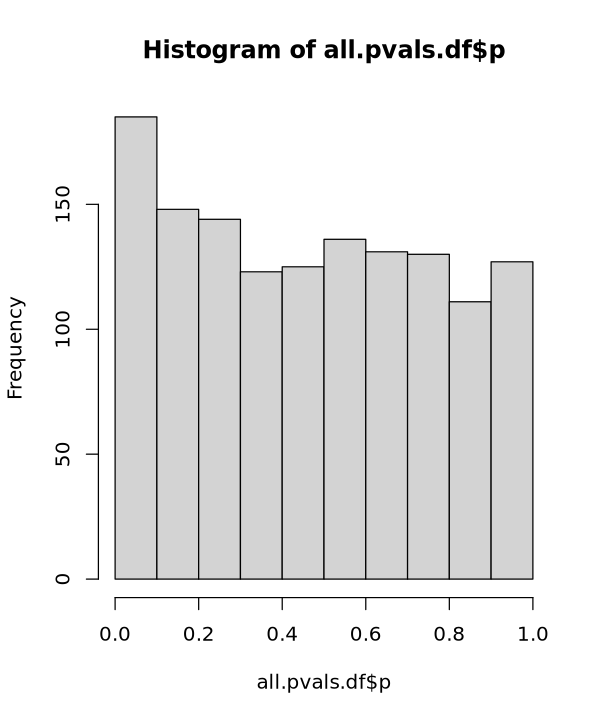

In [13]:
sig.cutoff <- 0.1
all.pvals.df$significant <- all.pvals.df$q < sig.cutoff
all.pvals.df <- all.pvals.df[order(all.pvals.df$q),]
head(all.pvals.df,10)
hist(all.pvals.df$p)

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


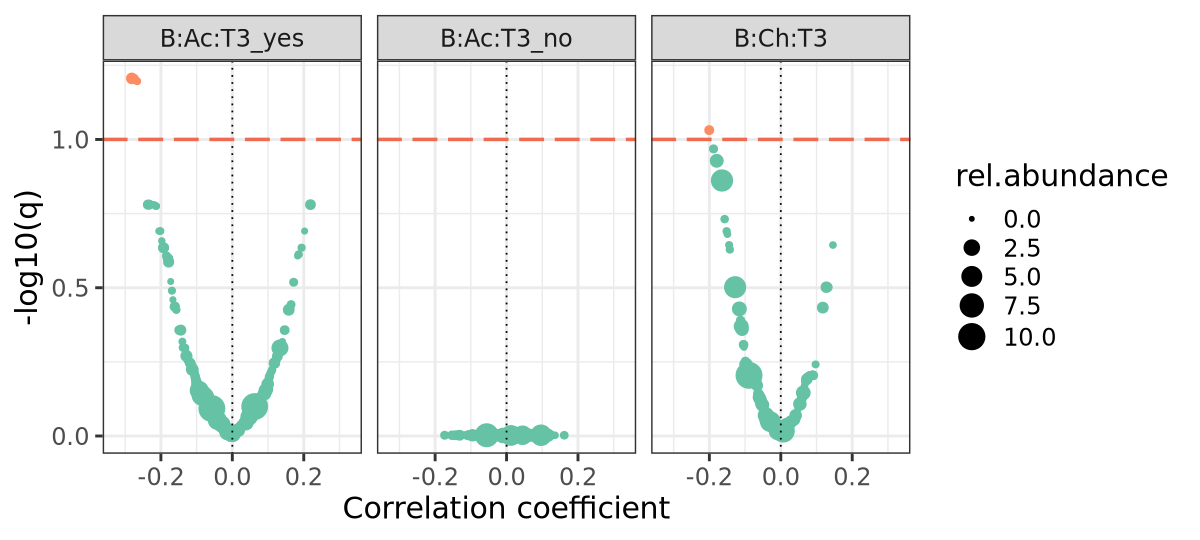

In [16]:
options(repr.plot.width = 10, repr.plot.height = 4.5)
g <- ggplot(all.pvals.df, aes(x=r, y=log.q))+
geom_point(aes(size=rel.abundance, color=significant))+
scale_color_brewer(palette="Set2")+
scale_size(limits = c(0,10), range = c(1,7))+
# ggrepel::geom_label_repel(data=all.pvals.df[all.pvals.df$significant,], aes(label=species), size=3, max.overlaps=50)+
labs(x="Correlation coefficient", y="-log10(q)")+
geom_vline(xintercept = 0, colour='black', linetype="dotted")+
geom_hline(yintercept = -log10(sig.cutoff), colour='coral2', linetype="longdash", linewidth=1)+
xlim(-0.33,0.33)+
scale_y_continuous(breaks = c(0,0.5,1.0,1.5))+
guides(color="none")+
facet_grid(~factor(group, level=c("B:Ac:T3_yes","B:Ac:T3_no","B:Ch:T3"))) +
theme_bw(base_size=18)
g
ggsave(g, width=10, height=4.5, file="../figs/AD_scorad_correlation.eps", device="eps")

# Fig 2d

In [17]:
cur.ps <- subset_samples(ps.rarefy, visit=="T3" & babymom=="B" & (group=="4"|!is.na(Scorad_Score_T3)))
scorad_melt <- psmelt(cur.ps)
scorad_melt$log.abundance <- log(scorad_melt$Abundance+1)
scorad_melt$Scorad_Score_T3[is.na(scorad_melt$Scorad_Score_T3)] <- 0

Warning message in psmelt(cur.ps):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency

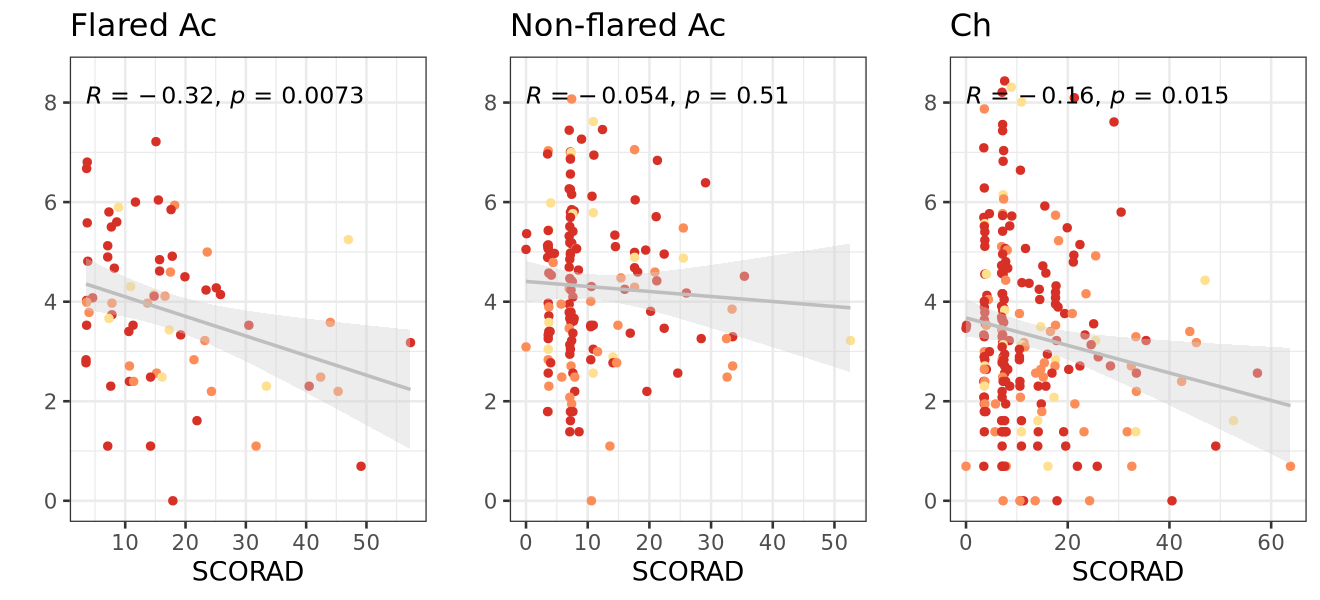

In [20]:
target <- "1359" #1359:Lactococcus cremoris; 1491:Clostridium botulinum; 137732:Granulicatella elegans
curMelt <- subset(scorad_melt, OTU==target)

options(repr.plot.width = 11, repr.plot.height = 5)
p1 <- ggscatter(subset(curMelt, site_specific=="Ac" & skin_swab_taken_at_eczema_T3=="yes"), 
    x = "Scorad_Score_T3", y = "log.abundance", 
    color = "group", 
    palette = c("#FC8D59","#FEE090","#D73027","#4575B4"),
    add = "reg.line",  # Add regressin line
    cor.coef = TRUE,
    cor.method = "pearson",
    add.params = list(color = "grey", fill = "lightgray"), # Customize reg. line
    conf.int = TRUE, # Add confidence interval
    cor.coef.size = 5,
    main="Flared Ac")+
    labs(x="SCORAD", y="")+
    guides(color="none")+
    ylim(0, 8.5)+
    theme_bw(base_size=16)

p2 <- ggscatter(subset(curMelt, (site_specific=="Ac" & any_eczema_ever_d=='yes' & skin_swab_taken_at_eczema_T3=="no")), 
    x = "Scorad_Score_T3", y = "log.abundance", 
    color = "group", 
    palette = c("#FC8D59","#FEE090","#D73027","#4575B4"),
    add = "reg.line",  # Add regressin line
    cor.coef = TRUE,
    cor.method = "pearson",
    add.params = list(color = "grey", fill = "lightgray"), # Customize reg. line
    conf.int = TRUE, # Add confidence interval
    cor.coef.size = 5,
    main="Non-flared Ac")+
    labs(x="SCORAD", y="")+
    guides(color="none")+
    ylim(0, 8.5)+
    theme_bw(base_size=16)

p3 <- ggscatter(subset(curMelt, (site_specific=="Ch" & (any_eczema_ever_d=='yes'))), 
    x = "Scorad_Score_T3", y = "log.abundance", 
    color = "group", 
    palette = c("#FC8D59","#FEE090","#D73027","#4575B4"),
    add = "reg.line",  # Add regressin line
    cor.coef = TRUE,
    cor.method = "pearson",
    add.params = list(color = "grey", fill = "lightgray"), # Customize reg. line
    conf.int = TRUE, # Add confidence interval
    cor.coef.size = 5,
    main="Ch")+
    labs(x="SCORAD", y="")+
    guides(color="none")+
    ylim(0, 8.5)+
    theme_bw(base_size=16)

g <- ggarrange(p1, p2, p3, ncol=3)
g
ggsave(g, width=11, height=5, file=paste0("../figs/AD_scorad_correlation_",target,".eps"), device="eps")